In [1]:
# Using the Moons Dataset with PyTorch
# The moons dataset is a 2D binary classification dataset from scikit-learn

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")


Libraries imported successfully!
PyTorch version: 2.7.1
Device: CPU


In [2]:
# 1. Generate the Moons Dataset
# The make_moons function creates a binary classification dataset with two classes
# arranged in two interleaving half circles (moons)

# Parameters:
# - n_samples: number of samples to generate
# - noise: standard deviation of Gaussian noise added to data
# - random_state: for reproducible results

n_samples = 1000
noise_level = 0.1

X, y = make_moons(n_samples=n_samples, noise=noise_level, random_state=42)

print(f"Dataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Number of class 0 samples: {np.sum(y == 0)}")
print(f"Number of class 1 samples: {np.sum(y == 1)}")
print(f"Feature range - X: [{X[:, 0].min():.2f}, {X[:, 0].max():.2f}]")
print(f"Feature range - Y: [{X[:, 1].min():.2f}, {X[:, 1].max():.2f}]")


Dataset shape: (1000, 2)
Labels shape: (1000,)
Number of class 0 samples: 500
Number of class 1 samples: 500
Feature range - X: [-1.22, 2.27]
Feature range - Y: [-0.75, 1.21]


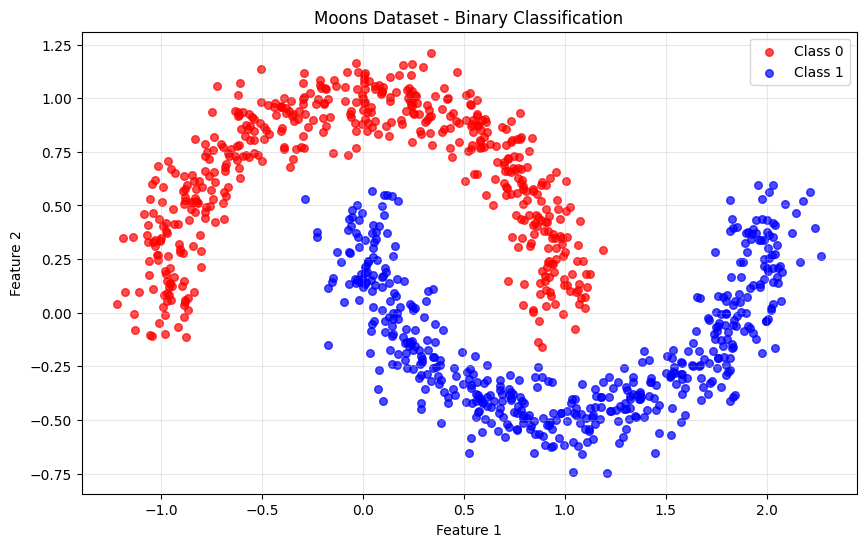


Dataset Statistics:
X mean: [0.499, 0.247]
X std:  [0.872, 0.503]


In [3]:
# 2. Visualize the Moons Dataset
plt.figure(figsize=(10, 6))

# Plot with different colors for each class
colors = ['red', 'blue']
class_names = ['Class 0', 'Class 1']

for i in range(2):
    mask = y == i
    plt.scatter(X[mask, 0], X[mask, 1], 
               c=colors[i], label=class_names[i], 
               alpha=0.7, s=30)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Moons Dataset - Binary Classification')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Show some statistics
print(f"\nDataset Statistics:")
print(f"X mean: [{X[:, 0].mean():.3f}, {X[:, 1].mean():.3f}]")
print(f"X std:  [{X[:, 0].std():.3f}, {X[:, 1].std():.3f}]")


In [6]:
# 3. Prepare Data for PyTorch
# Split the data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Optional: Standardize the features (recommended for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_train_tensor = torch.LongTensor(y_train)  # LongTensor for classification
y_test_tensor = torch.LongTensor(y_test)

print(f"Training set size: {X_train_tensor.shape}")
print(f"Test set size: {X_test_tensor.shape}")
print(f"Feature means after scaling: {X_train_tensor.mean(dim=0)}")
print(f"Feature stds after scaling: {X_train_tensor.std(dim=0)}")

# Check device and move tensors if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

print(f"Tensors moved to: {device}")


Training set size: torch.Size([800, 2])
Test set size: torch.Size([200, 2])
Feature means after scaling: tensor([4.7684e-09, 4.7684e-09])
Feature stds after scaling: tensor([1.0006, 1.0006])
Tensors moved to: cpu


In [7]:
# 4. Define a Neural Network Model for Binary Classification
class MoonClassifier(nn.Module):
    def __init__(self, input_size=2, hidden_size=10, num_classes=2):
        super(MoonClassifier, self).__init__()
        
        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # No activation here - will use CrossEntropyLoss
        return x

# Initialize the model
model = MoonClassifier(input_size=2, hidden_size=20, num_classes=2)
model = model.to(device)

# Print model architecture
print("Model Architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")


Model Architecture:
MoonClassifier(
  (fc1): Linear(in_features=2, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

Total parameters: 522
Trainable parameters: 522


In [ ]:
# 5. Training Setup
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training parameters
num_epochs = 100
batch_size = 32

# Create DataLoader for batch training (optional but recommended for larger datasets)
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"Training setup complete!")
print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")
print(f"Number of epochs: {num_epochs}")
print(f"Batch size: {batch_size}")
print(f"Number of batches per epoch: {len(train_loader)}")


In [ ]:
# 6. Training Loop
train_losses = []
train_accuracies = []

print("Starting training...")
model.train()  # Set model to training mode

for epoch in range(num_epochs):
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for batch_X, batch_y in train_loader:
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Track statistics
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += batch_y.size(0)
        correct_predictions += (predicted == batch_y).sum().item()
    
    # Calculate average loss and accuracy for the epoch
    avg_loss = epoch_loss / len(train_loader)
    accuracy = 100 * correct_predictions / total_samples
    
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    
    # Print progress every 20 epochs
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

print("Training completed!")


In [ ]:
# 7. Evaluate the Model
model.eval()  # Set model to evaluation mode

with torch.no_grad():
    # Test set evaluation
    test_outputs = model(X_test_tensor)
    _, test_predicted = torch.max(test_outputs.data, 1)
    test_accuracy = 100 * (test_predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    
    # Training set evaluation
    train_outputs = model(X_train_tensor)
    _, train_predicted = torch.max(train_outputs.data, 1)
    train_accuracy = 100 * (train_predicted == y_train_tensor).sum().item() / y_train_tensor.size(0)

print(f"Final Training Accuracy: {train_accuracy:.2f}%")
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss curve
ax1.plot(train_losses)
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)

# Accuracy curve
ax2.plot(train_accuracies)
ax2.set_title('Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# 8. Visualize Decision Boundary
def plot_decision_boundary(model, X, y, scaler, title="Decision Boundary"):
    model.eval()
    
    # Create a mesh grid
    h = 0.01
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Make predictions on the mesh grid
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    mesh_points_scaled = scaler.transform(mesh_points)
    mesh_tensor = torch.FloatTensor(mesh_points_scaled).to(device)
    
    with torch.no_grad():
        outputs = model(mesh_tensor)
        predictions = torch.softmax(outputs, dim=1)[:, 1]  # Probability of class 1
        predictions = predictions.cpu().numpy()
    
    predictions = predictions.reshape(xx.shape)
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, predictions, levels=50, alpha=0.6, cmap='RdYlBu')
    plt.colorbar(label='Probability of Class 1')
    
    # Plot the data points
    colors = ['red', 'blue']
    for i in range(2):
        mask = y == i
        plt.scatter(X[mask, 0], X[mask, 1], 
                   c=colors[i], label=f'Class {i}', 
                   alpha=0.8, s=30, edgecolors='black', linewidth=0.5)
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Plot decision boundary
plot_decision_boundary(model, X_test, y_test, scaler, 
                      "Decision Boundary on Test Set")


## Summary: Using the Moons Dataset with PyTorch

The moons dataset is perfect for learning binary classification with PyTorch because:

### Key Features:
1. **Non-linear decision boundary** - Requires neural networks (linear models won't work well)
2. **2D visualization** - Easy to plot and understand decision boundaries
3. **Balanced classes** - Equal number of samples for each class
4. **Controllable complexity** - Adjust noise level to make the problem easier/harder

### Dataset Parameters:
- `n_samples`: Number of data points to generate
- `noise`: Amount of Gaussian noise (0.0 = perfect moons, higher = more overlap)
- `random_state`: For reproducible results

### Common Use Cases:
- **Learning neural networks** - Great first dataset for classification
- **Algorithm comparison** - Compare different models on same non-linear problem
- **Hyperparameter tuning** - Quick training for testing different architectures
- **Machine unlearning research** - Simple dataset to test unlearning algorithms

### Next Steps for Machine Unlearning:
1. Train the model (as shown above)
2. Select specific samples to "forget"
3. Apply unlearning techniques (gradient ascent, data influence removal, etc.)
4. Verify the model has forgotten the target samples
5. Ensure retained performance on remaining data

This dataset provides an excellent foundation for your machine unlearning research!


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Create a simple synthetic dataset
X = torch.linspace(-3, 3, 100).reshape(-1, 1)
y = 2*X + 1 + 0.2*torch.randn(X.shape)  # y = 2x + 1 + noise
train_dataset = TensorDataset(X, y)

# Define a simple model
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)
        
    def forward(self, x):
        return self.linear(x)

# Initialize model and loss function
model = SimpleModel()
criterion = nn.MSELoss()

# Hyperparameters
class Args:
    def __init__(self):
        self.lr = 0.1
        self.sigma = 0.1  # Noise scale for differential privacy

args = Args()

# Print initial parameters
print("Initial parameters:")
for name, param in model.named_parameters():
    print(f"{name}: {param.data}")

# Training loop with differential privacy
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
batch = next(iter(dataloader))  # Get a single batch for demonstration

# Original values before update
print("\nBefore update:")
x, y = batch
y_hat = model(x)
loss = criterion(y_hat, y)
print(f"Loss: {loss.item():.6f}")

# Track original parameters and gradients
original_params = {}
for name, param in model.named_parameters():
    original_params[name] = param.data.clone()

# Backward pass
loss.backward()

# Print original gradients
print("\nOriginal gradients:")
original_grads = {}
for name, param in model.named_parameters():
    original_grads[name] = param.grad.clone()
    print(f"{name} gradient: {param.grad}")

# Apply differential privacy by adding noise to gradients
print("\nNoisy gradients (with DP):")
noisy_grads = {}
for name, param in model.named_parameters():
    # Generate and add noise
    noise = torch.normal(mean=0, std=args.sigma, size=param.grad.shape)
    print(f"Generated noise for {name}: {noise}")
    
    # Store original gradient
    noisy_grads[name] = param.grad.clone() + noise
    
    # Add noise to gradient
    param.grad += noise
    print(f"{name} gradient after noise: {param.grad}")

# Manual parameter update
print("\nParameters after update:")
for name, param in model.named_parameters():
    # Manual SGD step
    param.data = param.data - args.lr * param.grad
    print(f"{name}: {param.data}")
    
    # Calculate and display the effect of noise
    clean_update = original_params[name] - args.lr * original_grads[name]
    print(f"{name} without noise would be: {clean_update}")
    print(f"Difference due to noise: {param.data - clean_update}")
    
    # Reset gradient
    param.grad.zero_()

Initial parameters:
linear.weight: tensor([[0.1564]])
linear.bias: tensor([-0.8799])

Before update:
Loss: 12.457416

Original gradients:
linear.weight gradient: tensor([[-10.8582]])
linear.bias gradient: tensor([-2.6753])

Noisy gradients (with DP):
Generated noise for linear.weight: tensor([[-0.0130]])
linear.weight gradient after noise: tensor([[-10.8712]])
Generated noise for linear.bias: tensor([-0.0755])
linear.bias gradient after noise: tensor([-2.7508])

Parameters after update:
linear.weight: tensor([[1.2435]])
linear.weight without noise would be: tensor([[1.2422]])
Difference due to noise: tensor([[0.0013]])
linear.bias: tensor([-0.6048])
linear.bias without noise would be: tensor([-0.6124])
Difference due to noise: tensor([0.0076])
